In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
import pysam

# bulid mutpep

In [ ]:
gene2symble = pd.read_csv("/storage/liuyi/database/gene2ensembl.gz",sep = '\t',compression='gzip')
gene2pep = dict(zip(gene2symble['Ensembl_gene_identifier'],gene2symble['protein_accession.version']))
tran2pep = dict(zip(gene2symble['Ensembl_rna_identifier'],gene2symble['protein_accession.version']))

In [ ]:
import gzip

def cds_fa_protein(file_path):
    fasta_dict = {}
    current_protein_id = None
    current_sequence = []

    with gzip.open(file_path, 'rt') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if current_protein_id:
                    fasta_dict[current_protein_id] = ''.join(current_sequence)
                header_parts = line.split()
                for part in header_parts:
                    if part.startswith('[protein_id='):
                        current_protein_id = part.split('=')[1][:-1]
                        break
                current_sequence = []
            else:
                current_sequence.append(line)
        if current_protein_id:
            fasta_dict[current_protein_id] = ''.join(current_sequence)
    
    return fasta_dict

import re
def extract_letter_and_number(mutation):
    match = re.match(r'([A-Za-z])(\d+)([A-Za-z])', mutation)
    if match:
        first_letter = match.group(1)
        number = int(match.group(2))
        last_letter = match.group(3)
        return first_letter, number, last_letter

In [ ]:
cdsaadict = cds_fa_protein('./GCF_000001405.38_GRCh38.p12_translated_cds.faa.gz')

In [37]:
for sample in ['CRC-P59-T_2','CRC-P59-T_1','CRC-P19-T','CRC-P67-T']:

    snv = sc.read_h5ad(f'../../SNV_process/norm/{sample}.norm_snv.h5ad')
    rna = sc.read_h5ad(f'../../RNA_cluster/{sample}.rna.h5ad')
    snv.X = snv.layers['norm']
    annovar = pd.read_csv(f'/storage/liuyi/00.SNP_project/new_article/data/{sample}/vcf/{sample}.homo_multianno.txt',sep = '\t')
    annovar['snv'] = annovar['Chr']+'_'+annovar['Start'].map(str)+":"+annovar['Ref'] + ">"+annovar['Alt']
    aadict = dict(zip(annovar['snv'],annovar['AAChange.gencodev38']))
    snv.var['AA'] = snv.var['gene_ids'].map(aadict)
    nonsyaa = snv[:,snv.var['ExonicFunc']=='nonsynonymous SNV']
    all_list = []
    for idx,row in nonsyaa.var.iterrows():
        annovarinfos = row['AA']
        snv_name = row['gene_ids']
        transe_state = False
        dna_state = False
        gene_result = None

        aa_change_list = []
        seq_result = []
        mut_result = []
        from_list = []
        mut_pos = []
        rest_mut_pos = []

        psudo_mut = []

        aapos_list = []
        for annovarinfo in annovarinfos.split(','):
            gene_id,tran_id,exonid,cDNAchange,pchange = annovarinfo.split(':')
            aa,aa_pos,aa_after = extract_letter_and_number(pchange.split('.')[1])
            aapos_list.append(aa_pos)
            gene_id = gene_id.split('.')[0]
            trans_result = tran2pep.get(tran_id,False)
            if trans_result:
                cdsaa = cdsaadict.get(trans_result,False)
                if cdsaa and len(cdsaa)> aa_pos:
                    if cdsaa[aa_pos-1] == aa:
                        transe_state = True
                        seq_result.append(cdsaa[max(aa_pos-15,0):aa_pos+14])

                        before_seq = cdsaa[max(aa_pos-15,0):aa_pos-1]
                        before_len = len(before_seq)
                        after_seq = cdsaa[aa_pos:aa_pos+14]
                        after_len = len(after_seq)

                        mut_result.append(before_seq + aa_after + after_seq)
                        mut_pos.append(before_len)
                        rest_mut_pos.append(after_len)

                        aa_change_list.append(f'{aa}>{aa_after}')
                        from_list.append(tran_id)

                        if before_len != 14:
                            before_seq = '@' * (14 - before_len) + before_seq
                        if after_len != 14:
                            after_seq = after_seq + '@' * (14 - after_len)

                        psudo_mut.append(before_seq + aa_after + after_seq)



        if not transe_state:
            gene_result = gene2pep.get(gene_id,False)
            if gene_result:
                cdsaa = cdsaadict.get(gene_result,False)
                if cdsaa:
                    for aa_pos in aapos_list:
                        if len(cdsaa) <= aa_pos:
                            continue
                        if cdsaa[aa_pos-1]==aa:
                            transe_state = True
                            seq_result.append(cdsaa[max(aa_pos-15,0):aa_pos+14])

                            before_seq = cdsaa[max(aa_pos-15,0):aa_pos-1]
                            before_len = len(before_seq)
                            after_seq = cdsaa[aa_pos:aa_pos+14]
                            after_len = len(after_seq)

                            mut_result.append(before_seq + aa_after + after_seq)
                            mut_pos.append(before_len)
                            rest_mut_pos.append(after_len)

                            aa_change_list.append(f'{aa}>{aa_after}')
                            from_list.append(tran_id)

                            if before_len != 14:
                                before_seq = '@' * (14 - before_len) + before_seq
                            if after_len != 14:
                                after_seq = after_seq + '@' * (14 - after_len)

                            psudo_mut.append(before_seq + aa_after + after_seq)

        tmpdf = pd.DataFrame({'snv':[snv_name]*len(seq_result),'refaa':seq_result,'mutaa':mut_result,'aachange':aa_change_list,'pos_0base':mut_pos,'rest':rest_mut_pos,'psudo_mut':psudo_mut,'from':from_list})
        all_list.append(tmpdf)
    mutpepdf = pd.concat(all_list)
    mutpepdf = mutpepdf.drop_duplicates(['snv','refaa','mutaa','aachange'],ignore_index=True)
    window_pepdf = []
    for idx,row in mutpepdf.iterrows():
        snv_name = row['snv']
        seq = row['psudo_mut']
        windows_slide = []
        for window_size in range(8,16):
            for num in range(15-window_size,15):
                candidae_seq = seq[num:num+window_size]
                candidae_seq = candidae_seq.replace("@", "")
                if len(candidae_seq) == window_size:
                    windows_slide.append(candidae_seq)
        windows_slidedf = pd.DataFrame(windows_slide,columns = ['pep'])
        windows_slidedf['snv'] = snv_name
        window_pepdf.append(windows_slidedf)
    window_pepdf = pd.concat(window_pepdf)
    window_pepdf['pep'].to_csv(f'/storage/liuyi/00.SNP_project/new_article/Figure/Figure5/window_pepdf/{sample}.mutpep',index=None,header=None)
    window_pepdf.to_csv(f'/storage/liuyi/00.SNP_project/new_article/Figure/Figure5/window_pepdf/{sample}.mutpepdf.csv')

# collect mutpep

## collect pep from CDS

In [2]:
total_normal_pep = pd.read_csv("./GCF_000001405.38_GRCh38.p12_translated_cds.faa.8_15kmer.csv.gz",header=None,compression='gzip')

In [3]:
def search_db(sample):

    file_info = {
        f'neoantigen/{sample}/{sample}.search_result.IEDB.tsv': ('Epitope_Sequence', 'IEDB', 'Epitope_Parent Organism', 'Homo sapiens'),
        f'neoantigen/{sample}/{sample}.search_result.IEDB_T_Cell.tsv': ('Epitope_Sequence', 'IEDB_T', None, None),
        f'neoantigen/{sample}/{sample}.search_result.dbPepNeo.tsv': ('Mut_peptide', 'dbPepNeo', None, None),
        f'neoantigen/{sample}/{sample}.search_result.HLA_Ligand_Atlas.tsv': ('peptide_sequence', 'HLA_Ligand_Atlas', None, None),
        f'neoantigen/{sample}/{sample}.search_result.IEAtlas.tsv': ('Sequence', 'IEAtlas', None, None),
        f'neoantigen/{sample}/{sample}.MHC.Motif.Atlas.tsv': ('Peptide', 'MHC_Motif_Atlas', None, None),
    }
    dfs = []
    for file_path, (col_name, label, filter_col, filter_value) in file_info.items():
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, sep='\t')
            if filter_col and filter_value:
                df = df[df[filter_col] == filter_value]
            dfs.append(pd.DataFrame(zip(df[col_name], [label] * df.shape[0])))
    
    total_search = pd.concat(dfs)
    total_search.columns = ['pep','db']
    hla_remove = total_search[total_search['db']=='HLA_Ligand_Atlas']
    mutpepdf = total_search[total_search['db']!='HLA_Ligand_Atlas']
    mutpepdf = mutpepdf[~mutpepdf['pep'].isin(hla_remove['pep'])].copy()
    denor_mutpepdf = mutpepdf[~mutpepdf['pep'].isin(total_normal_pep[0])].copy()
    return denor_mutpepdf

In [4]:
denor_mutpepdf_dict = {}
pep2snvresult = {}
snvresult = {}
snv_adata = {}
for sample in ['CRC-P59-T_2','CRC-P59-T_1','CRC-P67-T']:
    denor_mutpepdf = search_db(sample)
    denor_mutpepdf = denor_mutpepdf.drop_duplicates(['pep','db'])
    denor_mutpepdf['sample'] = sample
    denor_mutpepdf_dict[sample] = denor_mutpepdf
    window_pepdf = pd.read_csv(f'./window_pepdf/{sample}.mutpepdf.csv',index_col = 0)
    tmpresult = window_pepdf[window_pepdf['pep'].isin(denor_mutpepdf['pep'])]
    pep2snvresult[sample] = tmpresult
    
    snv = sc.read_h5ad(f'../../SNV_process/norm/{sample}.norm_snv.h5ad')
    rna = sc.read_h5ad(f'../../RNA_cluster/{sample}.rna.h5ad')
    snv.obs['cluster'] = rna.obs['cluster']
    annovar = pd.read_csv(f'/storage/liuyi/00.SNP_project/new_article/data/{sample}/vcf/{sample}.homo_multianno.txt',sep = '\t')
    annovar['snv'] = annovar['Chr']+'_'+annovar['Start'].map(str)+":"+annovar['Ref'] + ">"+annovar['Alt']
    aadict = dict(zip(annovar['snv'],annovar['AAChange.gencodev38']))
    snv.var['AA'] = snv.var['gene_ids'].map(aadict)

    snv_adata[sample] = snv
    
    sub_snv = snv[:,snv.var['gene_ids'].isin(tmpresult['snv'])].copy()
    sub_snv.var['AA'] = sub_snv.var['AA'].map(lambda x :  list(set([ i.split(':')[4] for i in x.split(',')])))
    snvresult[sample] = sub_snv.var

In [5]:
statdf = pd.concat([denor_mutpepdf_dict['CRC-P67-T'],denor_mutpepdf_dict['CRC-P59-T_1'],denor_mutpepdf_dict['CRC-P59-T_2']])
statdf['values'] = 1

In [6]:
def sample_heatmap(df,colors = 'Set2',figsize = (20,1.5),save = None):
    import matplotlib.colors as mcolors
    def generate_color(n, cmap='Set1'):
        colormap = plt.get_cmap(cmap)
        color_dict = {i: mcolors.rgb2hex(colormap(i / n)) for i in range(1,n+1)}
        return color_dict
    
    if isinstance(colors,list):
        colors = dict(zip(range(len(colors)),colors))
    elif isinstance(colors,str):
        colors = generate_color(df.shape[0],cmap = colors)
        colors.update({0:'white'})
        
    data = df.values
    
    fig, ax = plt.subplots()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.add_patch(plt.Rectangle(
                (j, data.shape[0] - i - 1), 1, 1,
                facecolor=colors[data[i, j] * (i + 1)],
                edgecolor='black', linewidth=1
            ))

    ax.set_xlim(0, data.shape[1])
    ax.set_ylim(0, data.shape[0])
    
    ax.set_xticks(np.arange(data.shape[1]) + 0.5)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    
    ax.set_xticklabels(['' for _ in range(data.shape[1])])
    
    ax.set_yticklabels(df.index[::-1])
    
    ax.set_aspect('equal')
    ax.tick_params(left=False, bottom=False)
    if save != None:
        plt.savefig(save,bbox_inches = 'tight')
    plt.show()

In [7]:
data = pd.pivot_table(data = statdf, index = 'pep',columns='sample',values = 'values').fillna(0)
data_copy = data.copy()
data_copy['sum'] = np.sum(data_copy,axis = 1)
data_copy['subsum'] = np.sum(data_copy[['CRC-P59-T_1','CRC-P59-T_2']],axis = 1)
data_copy = data_copy.sort_values(['sum','subsum'],ascending=False)
data = data.loc[data_copy.index]

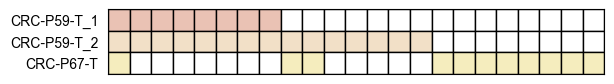

In [8]:
sample_heatmap(data.T,colors = ['white','#EAC2B4','#F2E0C7','#F5EDBE'],figsize = (30,1,5),save = './MainFigure/sample.hm.pdf')

In [9]:
dbstat = pd.pivot_table(data = statdf, index = 'pep',columns='db',values = 'values').fillna(0)
dbstat['HLA_Ligand_Atlas'] = 0
dbstat['PepFromCDS'] = 0
dbstat = dbstat.loc[data_copy.index]

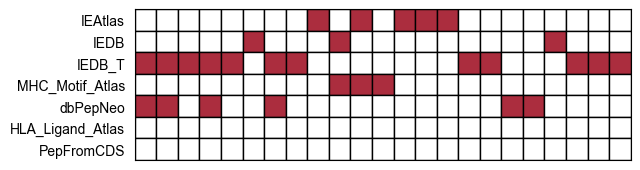

In [10]:
sample_heatmap(dbstat.T,colors = ['white']+['#AB2D3E']*7,figsize = (30,1,5),save = './MainFigure/db.hm.pdf')

In [11]:
exonic_df = []
for sample in ['CRC-P59-T_1','CRC-P59-T_2','CRC-P67-T']:
    exonic_tmp_df = snv_adata[sample].var['ExonicFunc'].value_counts().to_frame().reset_index()
    exonic_tmp_df['sample'] = sample
    exonic_df.append(exonic_tmp_df)
exonic_df = pd.concat(exonic_df,ignore_index= True)
exonic_df = exonic_df[exonic_df['ExonicFunc'] != '.']
exonic_df['ExonicFunc'] = exonic_df['ExonicFunc'].astype(str)
exonic_pivot_df = exonic_df.pivot_table(index='ExonicFunc', columns='sample', values='count', aggfunc='sum').fillna(0)
exonic_pivot_df = exonic_pivot_df[['CRC-P59-T_2','CRC-P59-T_1','CRC-P67-T']]

/tmp/ipykernel_3339126/2151076190.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


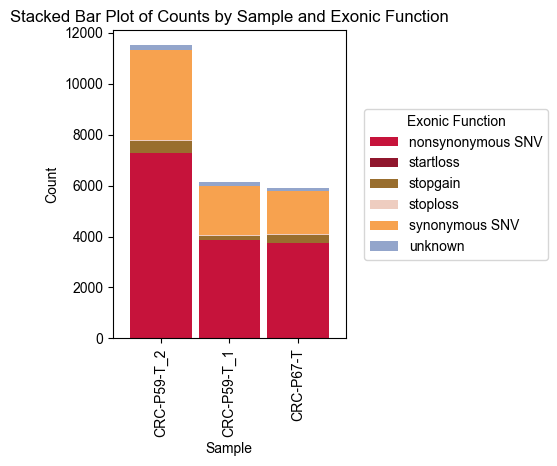

In [12]:
colors = {
    'nonsynonymous SNV': '#C6133B',
    'synonymous SNV': '#F7A24F',
    'startloss': '#90162D',
    'stopgain': '#996E2E',
    'stoploss': '#EECDC0',
    'unknown': '#93A5CB'
}

ax = exonic_pivot_df.T.plot(kind='bar', stacked=True, figsize=(3, 4), color=[colors[col] for col in exonic_pivot_df.index],width = 0.9)

plt.xlabel('Sample')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of Counts by Sample and Exonic Function')
plt.legend(title='Exonic Function', bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout()
plt.savefig(f'./MainFigure/exonic.bar.pdf')
plt.show()

In [13]:
snv_detail_list = []
for sample in ['CRC-P59-T_1','CRC-P59-T_2','CRC-P67-T']:
    snv_detail_list.append(set(snv_adata[sample][:,snv_adata[sample].var['ExonicFunc'] == 'nonsynonymous SNV'].var_names))

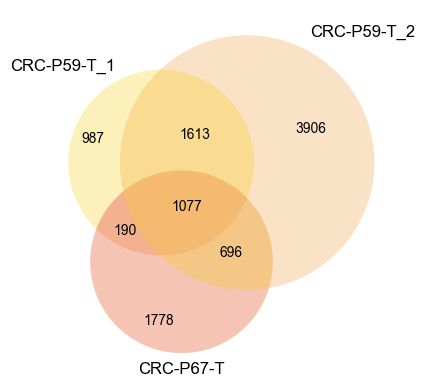

In [14]:
from matplotlib_venn import venn3
venn = venn3(snv_detail_list,['CRC-P59-T_1','CRC-P59-T_2','CRC-P67-T'])
venn.get_patch_by_id('100').set_color('#FCF1BA')
venn.get_patch_by_id('010').set_color('#F9E2C6')
venn.get_patch_by_id('001').set_color('#F6C4B5')
venn.get_patch_by_id('110').set_color('#F9DC92')
venn.get_patch_by_id('101').set_color('#F3B18F')
venn.get_patch_by_id('011').set_color('#F5C787')
venn.get_patch_by_id('111').set_color('#F4BA6F')

venn.get_patch_by_id('100').set_alpha(1)
venn.get_patch_by_id('010').set_alpha(1)
venn.get_patch_by_id('001').set_alpha(1)
venn.get_patch_by_id('110').set_alpha(1)
venn.get_patch_by_id('101').set_alpha(1)
venn.get_patch_by_id('011').set_alpha(1)
venn.get_patch_by_id('111').set_alpha(1)

plt.savefig('./MainFigure/veen.pdf')

In [15]:
gene_stat =[]
for sample in ['CRC-P59-T_1','CRC-P59-T_2','CRC-P67-T']:
    gene_name = snvresult[sample]['gene_name'].to_frame()
    gene_name['sample'] = sample
    gene_stat.append(gene_name)
gene_stat = pd.concat(gene_stat)
gene_stat['gene_name'] = gene_stat['gene_name'].map(lambda x : x.split(';')[0])
gene_stat = gene_stat.reset_index(drop=True)

In [16]:
colors = {'CRC-P67-T': '#EEC6B8', 'CRC-P59-T_1': '#FAF1C0', 'CRC-P59-T_2': '#F5E3C9'}

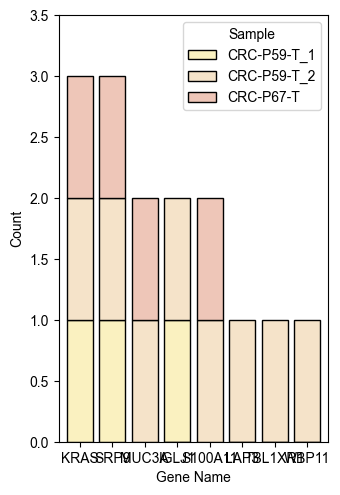

In [17]:
pivot_df = gene_stat.pivot_table(index='gene_name', columns='sample', aggfunc='size', fill_value=0)
pivot_df['total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='total', ascending=False)
pivot_df = pivot_df.drop(columns='total')
pivot_df.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_df.columns], figsize=(3.5, 5),width = 0.8,edgecolor = 'black')
plt.xlabel('Gene Name')
plt.ylabel('Count')
plt.legend(title='Sample')
plt.xticks(rotation=0)
plt.tight_layout()
plt.ylim(0,3.5)
plt.savefig('./MainFigure/gene_bar.pdf')
plt.show()

In [1635]:
pep2snvresult['CRC-P59-T_2']
# pep2snvresult['CRC-P67-T']

,pep,snv,gene,sample
7,LTVLGQPK,chr22_22893806:G>C,IGLJ1;IGLL5,CRC-P59-T_2
10,LSKTEFPSF,chr1_152033685:A>G,S100A11,CRC-P59-T_2
15,IMAHCILDL,chr1_225786912:A>G,SRP9,CRC-P59-T_2
13,AAADAAAAA,chr3_177051599:G>T,TBL1XR1,CRC-P59-T_2
69,IDEQENWQEGKENI,chr4_17582359:T>G,LAP3,CRC-P59-T_2
7,DGVGKSAL,chr12_25245350:C>T,KRAS,CRC-P59-T_2
14,GADGVGKSA,chr12_25245350:C>T,KRAS,CRC-P59-T_2
19,KLVVVGADGV,chr12_25245350:C>T,KRAS,CRC-P59-T_2
21,VVVGADGVGK,chr12_25245350:C>T,KRAS,CRC-P59-T_2
24,GADGVGKSAL,chr12_25245350:C>T,KRAS,CRC-P59-T_2


In [1632]:
snvresult['CRC-P59-T_2']

,gene_ids,feature_types,SNVDepth,SNVCount,n_cells,Func,ExonicFunc,gene_name,gene_lenth,Func_L0,AA
chr22_22893806:G>C,chr22_22893806:G>C,Gene Expression,402.0,399.0,339,exonic,nonsynonymous SNV,IGLJ1;IGLL5,126;8327,Exonic,"[p.V39L, p.V105L, p.V106L]"
chr1_152033685:A>G,chr1_152033685:A>G,Gene Expression,134.0,134.0,134,exonic,nonsynonymous SNV,S100A11,15401,Exonic,[p.L40P]
chr1_225786912:A>G,chr1_225786912:A>G,Gene Expression,276.0,177.0,173,exonic,nonsynonymous SNV,SRP9,12655,Exonic,[p.I64M]
chr3_177051599:G>T,chr3_177051599:G>T,Gene Expression,43.0,41.0,41,exonic,nonsynonymous SNV,TBL1XR1,208660,Exonic,"[p.A108D, p.A24D, p.A111D]"
chr4_17582359:T>G,chr4_17582359:T>G,Gene Expression,50.0,46.0,45,exonic,nonsynonymous SNV,LAP3,30780,Exonic,"[p.H84Q, p.H115Q]"
chr12_25245350:C>T,chr12_25245350:C>T,Gene Expression,116.0,88.0,87,exonic,nonsynonymous SNV,KRAS,46147,Exonic,[p.G12D]
chr7_100956022:C>T,chr7_100956022:C>T,Gene Expression,29.0,19.0,19,exonic,nonsynonymous SNV,MUC3A,18813,Exonic,[p.P1415S]
chr12_14793743:C>T,chr12_14793743:C>T,Gene Expression,20.0,13.0,13,exonic,nonsynonymous SNV,WBP11,18904,Exonic,[p.E301K]


# binding Affinity

In [1496]:
badf = pd.read_csv('./BA/ba.tsv',sep = '\t')
badf = badf.loc[(badf['A1101']+badf['C0702']).sort_values(ascending=False).index]

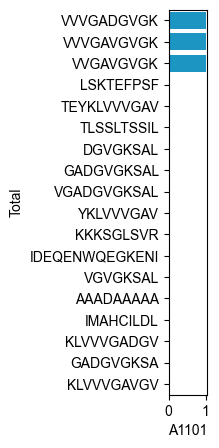

In [1509]:
fig,ax = plt.subplots(figsize = (0.5,5))
sns.barplot(data = badf, y= 'Total',x = 'A1101',color = '#00A1DF',ax = ax)
fig.savefig('./MainFigure/ba.A1101.pdf')

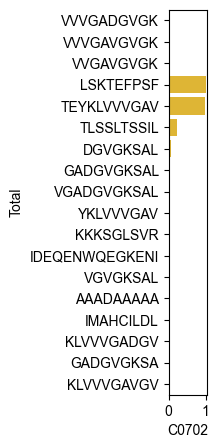

In [1511]:
fig,ax = plt.subplots(figsize = (0.5,5))
sns.barplot(data = badf, y= 'Total',x = 'C0702',color = '#FAC319',ax = ax)
fig.savefig('./MainFigure/ba.C0702.pdf')

# get_read from bam

In [7]:
import pysam
denor_mutpepdf_dict
pep2snvresult

In [18]:
# with open('pep.fasta','w') as f:
#     for sample in ['CRC-P59-T_2','CRC-P59-T_1','CRC-P67-T']:
#         pepgenedict = dict(zip(snvresult[sample]['gene_ids'],snvresult[sample]['gene_name']))
#         tmp = pep2snvresult[sample]
#         tmp['gene'] = tmp['snv'].map(pepgenedict)
#         tmp['sample'] = sample
#         for idx,row in tmp.iterrows():
#             pep,snv,gene,sample = row
#             f.write(f'> {snv}|||{gene}|||{sample}\n')
#             f.write(f'{pep}\n')

In [1423]:
for idx,row in tmp.iterrows():
    break

In [1425]:
pep,snv,gene,sample = row

In [1482]:
snvresult['CRC-P67-T']

,gene_ids,feature_types,SNVDepth,SNVCount,n_cells,Func,ExonicFunc,gene_name,gene_lenth,Func_L0,AA
chr1_225786912:A>G,chr1_225786912:A>G,Gene Expression,407.0,27.0,27,exonic,nonsynonymous SNV,SRP9,12655,Exonic,[p.I64M]
chr1_152033685:A>G,chr1_152033685:A>G,Gene Expression,49.0,48.0,48,exonic,nonsynonymous SNV,S100A11,15401,Exonic,[p.L40P]
chr12_25245350:C>A,chr12_25245350:C>A,Gene Expression,235.0,32.0,32,exonic,nonsynonymous SNV,KRAS,46147,Exonic,[p.G12V]
chr7_100956022:C>T,chr7_100956022:C>T,Gene Expression,95.0,15.0,15,exonic,nonsynonymous SNV,MUC3A,18813,Exonic,[p.P1415S]


## KRAS

In [21]:
sample = 'CRC-P67-T'
snv_name = "chr12_25245350:C>A"
snv_proxy = snv_name.split(':')[0]
chrom = snv_proxy.split('_')[0]
pos = int(snv_proxy.split('_')[1])

ref = snv_name.split(':')[1].split('>')[0]
alt = snv_name.split(':')[1].split('>')[1]


resultfrombam = []
bam_file = f"/storage/liuyi/00.SNP_project/new_article/Figure/Figure5/subbam/{sample}/{snv_proxy}.bam"
inputpysam = pysam.AlignmentFile(bam_file, "rb")
for i in inputpysam.pileup(chrom,pos-1,pos,truncate=True,min_mapping_quality=10): # 1-base
    for pileupread in i.pileups:
        if not pileupread.is_del and not pileupread.is_refskip and not pileupread.alignment.is_qcfail and not pileupread.alignment.is_duplicate:
            read_base = pileupread.alignment.query_sequence[pileupread.query_position]
            x = pileupread.alignment.get_tag('Cx')
            y = pileupread.alignment.get_tag('Cy')
            resultfrombam.append([x,y,read_base])
resultfrombam = pd.DataFrame(resultfrombam,columns = ['x','y','base'])
resultfrombam['x'] = resultfrombam['x']//100*100
resultfrombam['y'] = resultfrombam['y']//100*100
resultfrombam['DNB'] = 'DNB_' + resultfrombam['x'].map(str) + '_' + resultfrombam['y'].map(str)
resultfrombam = resultfrombam.drop_duplicates(['DNB','base'])

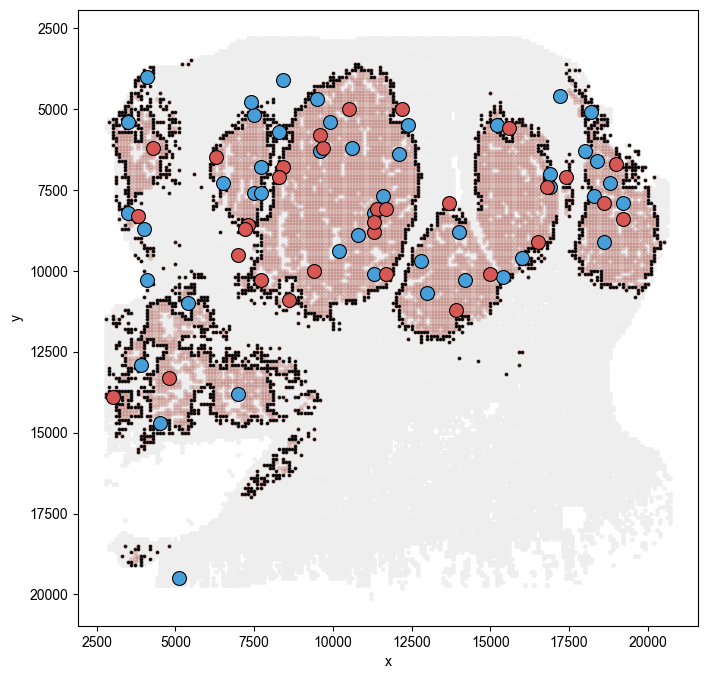

In [22]:
snv = snv_adata[sample]
sub_snv = snv[snv.obs['cluster'] == 'Tumor'].copy()
sub_snv.obs['x'] = sub_snv.obsm['spatial'][:,0]
sub_snv.obs['y'] = sub_snv.obsm['spatial'][:,1]
snv_df = sub_snv.obs[['x','y']].copy()
import concave_hull
points = snv_df[['x','y']].values
hull = concave_hull.concave_hull(points,concavity = 0.01)
s = 5
fig,ax = plt.subplots(figsize = (8,8))
sns.scatterplot(x = snv.obsm['spatial'][:,0],y = snv.obsm['spatial'][:,1],s = 10,edgecolor = None,color = '#EEEEEE',rasterized =True)
sns.scatterplot(x = snv[snv.obs['cluster']=='Tumor'].obsm['spatial'][:,0],y = snv[snv.obs['cluster']=='Tumor'].obsm['spatial'][:,1],s = 10,alpha = 0.3,edgecolor = None,color = '#B4635C',rasterized =True)
sns.scatterplot(x = hull[:,0],y = hull[:,1],s = s,edgecolor = None,color = 'black',markers='s',rasterized =True)
sns.scatterplot(data = resultfrombam[resultfrombam['base'] == ref] ,x = 'x', y = 'y',color = '#479FDA',s = 100,edgecolor = 'black',rasterized =True)
sns.scatterplot(data = resultfrombam[resultfrombam['base'] == alt] ,x = 'x', y = 'y',color = '#D75755',s = 100,edgecolor = 'black',rasterized =True)
ax.invert_yaxis()
fig.savefig(f'./MainFigure/{sample}.snv.Tumor.pdf')

In [41]:
resultfrombam['cluster'] =  resultfrombam['DNB'].map(dict(zip(snv.obs_names,snv.obs['cluster'])))
resultfrombam[~resultfrombam['cluster'].isna()][['base', 'cluster']].to_csv(f'{sample}_{snv_name}.csv', index=False)

In [858]:
resultfrombam['cluster'] =  resultfrombam['DNB'].map(dict(zip(snv.obs_names,snv.obs['cluster'])))

In [859]:
result_counts_1 = resultfrombam[resultfrombam['base']==ref].value_counts('cluster').to_frame()
result_counts_2 = resultfrombam[resultfrombam['base']==alt].value_counts('cluster').to_frame()
result_counts = pd.concat([result_counts_1,result_counts_2],axis = 1).fillna(0)
result_counts.columns = ['ref','alt']

result_counts_percent = result_counts.div(result_counts.sum(axis=0), axis=1) * 100
result_counts_percent.T.reset_index().to_csv(f'./{sample}.change.csv',index=None)

In [42]:
sample = 'CRC-P59-T_2'
snv_name = "chr12_25245350:C>T"
snv_proxy = snv_name.split(':')[0]
chrom = snv_proxy.split('_')[0]
pos = int(snv_proxy.split('_')[1])

ref = snv_name.split(':')[1].split('>')[0]
alt = snv_name.split(':')[1].split('>')[1]



resultfrombam = []
bam_file = f"/storage/liuyi/00.SNP_project/new_article/Figure/Figure5/subbam/{sample}/{snv_proxy}.bam"
inputpysam = pysam.AlignmentFile(bam_file, "rb")
for i in inputpysam.pileup(chrom,pos-1,pos,truncate=True,min_mapping_quality=10): # 1-base
    for pileupread in i.pileups:
        if not pileupread.is_del and not pileupread.is_refskip and not pileupread.alignment.is_qcfail and not pileupread.alignment.is_duplicate:
            read_base = pileupread.alignment.query_sequence[pileupread.query_position]
            x = pileupread.alignment.get_tag('Cx')
            y = pileupread.alignment.get_tag('Cy')
            resultfrombam.append([x,y,read_base])
resultfrombam = pd.DataFrame(resultfrombam,columns = ['x','y','base'])
resultfrombam['x'] = resultfrombam['x']//100*100
resultfrombam['y'] = resultfrombam['y']//100*100
resultfrombam['DNB'] = 'DNB_' + resultfrombam['x'].map(str) + '_' + resultfrombam['y'].map(str)
resultfrombam = resultfrombam.drop_duplicates(['DNB','base'])

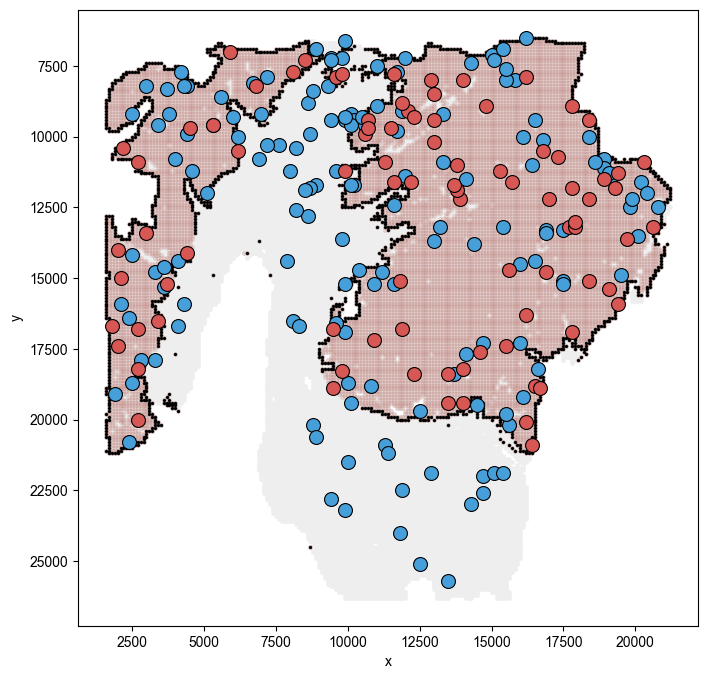

In [43]:
snv = snv_adata[sample]
sub_snv = snv[snv.obs['cluster'] == 'Tumor'].copy()
sub_snv.obs['x'] = sub_snv.obsm['spatial'][:,0]
sub_snv.obs['y'] = sub_snv.obsm['spatial'][:,1]
snv_df = sub_snv.obs[['x','y']].copy()
import concave_hull
points = snv_df[['x','y']].values
hull = concave_hull.concave_hull(points,concavity = 0.01)

fig,ax = plt.subplots(figsize = (8,8))
sns.scatterplot(x = snv.obsm['spatial'][:,0],y = snv.obsm['spatial'][:,1],s = 10,edgecolor = None,color = '#EEEEEE',rasterized =True)
sns.scatterplot(x = snv[snv.obs['cluster']=='Tumor'].obsm['spatial'][:,0],y = snv[snv.obs['cluster']=='Tumor'].obsm['spatial'][:,1],s = 10,alpha = 0.2,edgecolor = None,color = '#B4635C',rasterized =True)
sns.scatterplot(x = hull[:,0],y = hull[:,1],s = 5,edgecolor = None,color = 'black',markers='s',rasterized =True)
sns.scatterplot(data = resultfrombam[resultfrombam['base'] == ref] ,x = 'x', y = 'y',color = '#479FDA',s = 100,edgecolor = 'black',rasterized =True)
sns.scatterplot(data = resultfrombam[resultfrombam['base'] == alt] ,x = 'x', y = 'y',color = '#D75755',s = 100,edgecolor = 'black',rasterized =True)
ax.invert_yaxis()
# fig.savefig(f'./MainFigure/{sample}.snv.Tumor.pdf')

In [44]:
resultfrombam['cluster'] =  resultfrombam['DNB'].map(dict(zip(snv.obs_names,snv.obs['cluster'])))
resultfrombam[~resultfrombam['cluster'].isna()][['base', 'cluster']].to_csv(f'{sample}_{snv_name}.csv', index=False)

In [871]:
result_counts_1 = resultfrombam[resultfrombam['base']==ref].value_counts('cluster').to_frame()
result_counts_2 = resultfrombam[resultfrombam['base']==alt].value_counts('cluster').to_frame()
result_counts = pd.concat([result_counts_1,result_counts_2],axis = 1).fillna(0)
result_counts.columns = ['ref','alt']

result_counts_percent = result_counts.div(result_counts.sum(axis=0), axis=1) * 100
result_counts_percent.T.reset_index().to_csv(f'./{sample}.change.csv',index=None)

# S100A11

In [48]:
sample = 'CRC-P59-T_2'
snv_name = "chr1_152033685:A>G"
snv_proxy = snv_name.split(':')[0]
chrom = snv_proxy.split('_')[0]
pos = int(snv_proxy.split('_')[1])

ref = snv_name.split(':')[1].split('>')[0]
alt = snv_name.split(':')[1].split('>')[1]

resultfrombam = []
bam_file = f"/storage/liuyi/00.SNP_project/new_article/Figure/Figure5/subbam/{sample}/{snv_proxy}.bam"
inputpysam = pysam.AlignmentFile(bam_file, "rb")
for i in inputpysam.pileup(chrom,pos-1,pos,truncate=True,min_mapping_quality=10): # 1-base
    for pileupread in i.pileups:
        if not pileupread.is_del and not pileupread.is_refskip and not pileupread.alignment.is_qcfail and not pileupread.alignment.is_duplicate:
            read_base = pileupread.alignment.query_sequence[pileupread.query_position]
            x = pileupread.alignment.get_tag('Cx')
            y = pileupread.alignment.get_tag('Cy')
            resultfrombam.append([x,y,read_base])
resultfrombam = pd.DataFrame(resultfrombam,columns = ['x','y','base'])
resultfrombam = pd.DataFrame(resultfrombam,columns = ['x','y','base'])
resultfrombam['x'] = resultfrombam['x']//100*100
resultfrombam['y'] = resultfrombam['y']//100*100
resultfrombam['DNB'] = 'DNB_' + resultfrombam['x'].map(str) + '_' + resultfrombam['y'].map(str)
resultfrombam = resultfrombam.drop_duplicates(['DNB','base'])

[W::hts_idx_load3] The index file is older than the data file: /storage/liuyi/00.SNP_project/new_article/Figure/Figure5/subbam/CRC-P59-T_2/chr1_152033685.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /storage/liuyi/00.SNP_project/new_article/Figure/Figure5/subbam/CRC-P59-T_2/chr1_152033685.bam.bai


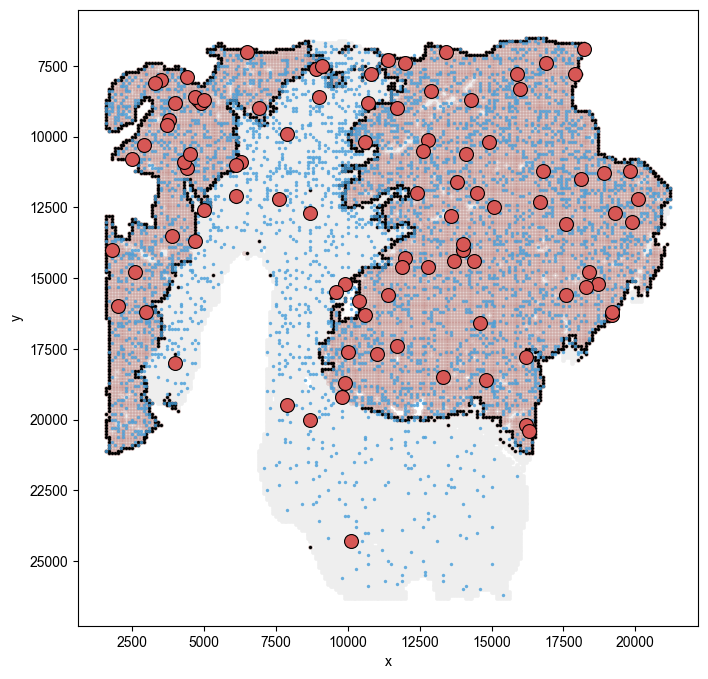

In [49]:
snv = snv_adata[sample]
sub_snv = snv[snv.obs['cluster'] == 'Tumor'].copy()
sub_snv.obs['x'] = sub_snv.obsm['spatial'][:,0]
sub_snv.obs['y'] = sub_snv.obsm['spatial'][:,1]
snv_df = sub_snv.obs[['x','y']].copy()
import concave_hull
points = snv_df[['x','y']].values
hull = concave_hull.concave_hull(points,concavity = 0.01)

fig,ax = plt.subplots(figsize = (8,8))
sns.scatterplot(x = snv.obsm['spatial'][:,0],y = snv.obsm['spatial'][:,1],s = 10,edgecolor = None,color = '#EEEEEE',rasterized =True)
sns.scatterplot(x = snv[snv.obs['cluster']=='Tumor'].obsm['spatial'][:,0],y = snv[snv.obs['cluster']=='Tumor'].obsm['spatial'][:,1],s = 10,alpha = 0.2,edgecolor = None,color = '#B4635C',rasterized =True)
sns.scatterplot(x = hull[:,0],y = hull[:,1],s = 5,edgecolor = None,color = 'black',markers='s',rasterized =True)
sns.scatterplot(data = resultfrombam[resultfrombam['base'] == ref] ,x = 'x', y = 'y',color = '#479FDA',s = 5,edgecolor = None,rasterized =True,alpha = 0.8)
sns.scatterplot(data = resultfrombam[resultfrombam['base'] == alt] ,x = 'x', y = 'y',color = '#D75755',s = 100,edgecolor = 'black',rasterized =True)
ax.invert_yaxis()
fig.savefig(f'./MainFigure/{sample}.s100A11.Tumor.pdf')

In [54]:
resultfrombam['cluster'] =  resultfrombam['DNB'].map(dict(zip(snv.obs_names,snv.obs['cluster'])))
resultfrombam = resultfrombam[resultfrombam['base'].isin(['A','G'])]
resultfrombam[~resultfrombam['cluster'].isna()][['base', 'cluster']].to_csv(f'{sample}_{snv_name}.csv', index=False)

In [53]:
resultfrombam = resultfrombam[resultfrombam['base'].isin(['A','G'])]

,x,y,base,DNB,cluster
0,10200,19300,A,DNB_10200_19300,Tumor
1,16300,13500,A,DNB_16300_13500,Tumor
2,15300,18700,A,DNB_15300_18700,Adjacent
3,3500,10900,A,DNB_3500_10900,Tumor
4,7000,11000,A,DNB_7000_11000,Adjacent
...,...,...,...,...,...
6038,7400,14800,A,DNB_7400_14800,Adjacent
6039,11900,13400,A,DNB_11900_13400,Adjacent
6040,17500,10200,A,DNB_17500_10200,Tumor
6041,11600,7200,A,DNB_11600_7200,Tumor


In [1655]:
tmp = resultfrombam[resultfrombam['base'] == alt].copy()
tmp['dnb'] = 'DNB_' + (tmp['x']//100*100).map(str) + '_' + (tmp['y']//100*100).map(str)
tmp.to_csv('../../s100a11.csv')

In [1656]:
tmp

,x,y,base,dnb
563,16216,17899,G,DNB_16200_17800
665,19332,12753,G,DNB_19300_12700
1436,2087,16011,G,DNB_2000_16000
1936,13499,7084,G,DNB_13400_7000
2285,12865,10199,G,DNB_12800_10100
...,...,...,...,...
5900,5091,8761,G,DNB_5000_8700
5934,2955,10324,G,DNB_2900_10300
5955,9135,7520,G,DNB_9100_7500
5982,18970,11341,G,DNB_18900_11300


In [2]:
sample = 'CRC-P67-T'
snv_name = "chr1_152033685:A>G"
snv_proxy = snv_name.split(':')[0]
chrom = snv_proxy.split('_')[0]
pos = int(snv_proxy.split('_')[1])

ref = snv_name.split(':')[1].split('>')[0]
alt = snv_name.split(':')[1].split('>')[1]

resultfrombam = []
bam_file = f"/storage/liuyi/00.SNP_project/new_article/Figure/Figure5/subbam/{sample}/{snv_proxy}.bam"
inputpysam = pysam.AlignmentFile(bam_file, "rb")
for i in inputpysam.pileup(chrom,pos-1,pos,truncate=True,min_mapping_quality=10): # 1-base
    for pileupread in i.pileups:
        if not pileupread.is_del and not pileupread.is_refskip and not pileupread.alignment.is_qcfail and not pileupread.alignment.is_duplicate:
            read_base = pileupread.alignment.query_sequence[pileupread.query_position]
            x = pileupread.alignment.get_tag('Cx')
            y = pileupread.alignment.get_tag('Cy')
            resultfrombam.append([x,y,read_base])
            
            
resultfrombam = pd.DataFrame(resultfrombam,columns = ['x','y','base'])

In [3]:
x

16400

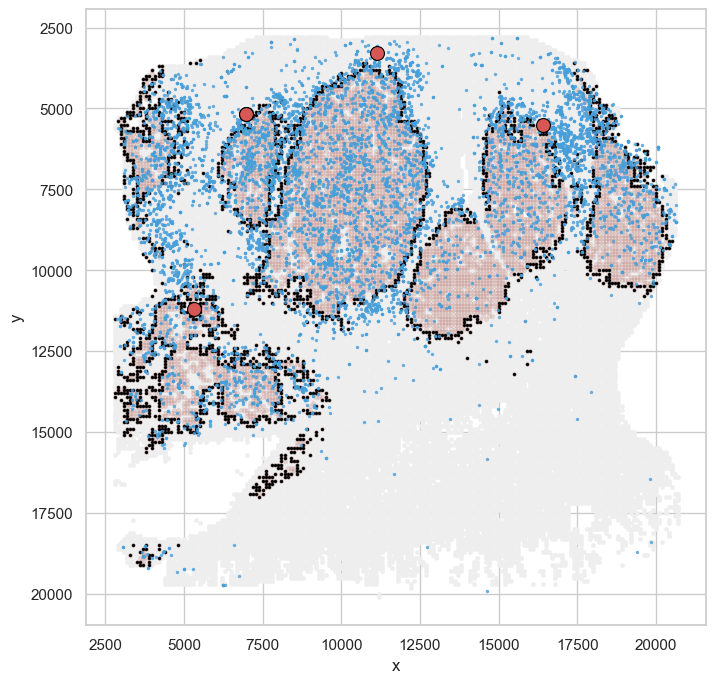

In [1646]:
snv = snv_adata[sample]
sub_snv = snv[snv.obs['cluster'] == 'Tumor'].copy()
sub_snv.obs['x'] = sub_snv.obsm['spatial'][:,0]
sub_snv.obs['y'] = sub_snv.obsm['spatial'][:,1]
snv_df = sub_snv.obs[['x','y']].copy()
import concave_hull
points = snv_df[['x','y']].values
hull = concave_hull.concave_hull(points,concavity = 0.01)

fig,ax = plt.subplots(figsize = (8,8))
sns.scatterplot(x = snv.obsm['spatial'][:,0],y = snv.obsm['spatial'][:,1],s = 10,edgecolor = None,color = '#EEEEEE',rasterized =True)
sns.scatterplot(x = snv[snv.obs['cluster']=='Tumor'].obsm['spatial'][:,0],y = snv[snv.obs['cluster']=='Tumor'].obsm['spatial'][:,1],s = 10,alpha = 0.2,edgecolor = None,color = '#B4635C',rasterized =True)
sns.scatterplot(x = hull[:,0],y = hull[:,1],s = 5,edgecolor = None,color = 'black',markers='s',rasterized =True)
sns.scatterplot(data = resultfrombam[resultfrombam['base'] == ref] ,x = 'x', y = 'y',color = '#479FDA',s = 5,edgecolor = None,rasterized =True,alpha = 0.8)
sns.scatterplot(data = resultfrombam[resultfrombam['base'] == alt] ,x = 'x', y = 'y',color = '#D75755',s = 100,edgecolor = 'black',rasterized =True)
ax.invert_yaxis()
# fig.savefig(f'./MainFigure/{sample}.s100A11.Tumor.pdf')

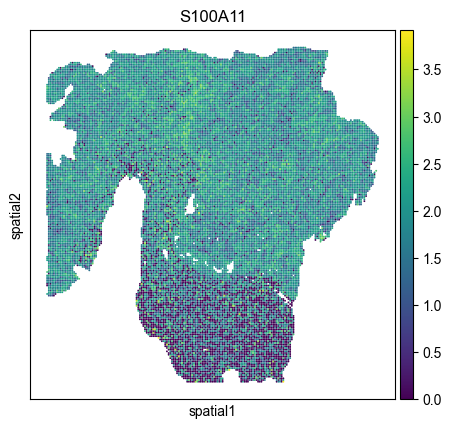

In [1440]:
rna = sc.read_h5ad(f'../../RNA_cluster/{sample}.rna.h5ad')
sc.pl.spatial(rna,color = 'S100A11',spot_size = 110)

In [1664]:
def get_color(row):
    if row['mut'] == row['raw']:
        return 'grey'
    elif (row['mut']-row['raw'])>0:
        if row['mut']<0.1:
            return "grey"
        return '#E84B50'
    else:
        if row['raw']<0.1:
            return "grey"
        else:
            if np.abs(row['raw'] - row['mut'])<0.1:
                return "#FAC319"
        return "#00A1DF"

In [1665]:
change = pd.read_csv('./BA/hlac0702.change.csv',sep = '\t')
change['color'] = change.apply(get_color,axis = 1)

In [1666]:
change

,Total,mut,raw,color
0,DGVGKSAL,0.0653,0.0000,grey
1,GADGVGKSA,0.0000,0.0000,grey
2,KLVVVGADGV,0.0000,0.0000,grey
3,VVVGADGVGK,0.0136,0.0017,grey
4,GADGVGKSAL,0.0385,0.0006,grey
5,VGADGVGKSAL,0.0026,0.0006,grey
6,IMAHCILDL,0.0000,0.0000,grey
7,LSKTEFPSF,0.9998,0.9999,#FAC319
8,VGVGKSAL,0.0000,0.0000,grey
9,YKLVVVGAV,0.0018,0.0000,grey


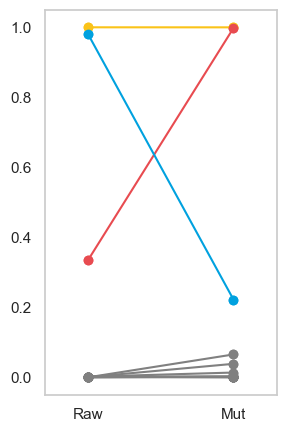

In [1667]:
fig,ax = plt.subplots(figsize=(3, 5))

for index, row in change.iterrows():
    ax.scatter(['Raw', 'Mut'], [row['raw'], row['mut']], label=row['Total'],color = row['color'])
    ax.plot(['Raw', 'Mut'], [row['raw'], row['mut']], linestyle='-', marker='o',color = row['color'])
ax.set_xlim(-0.3,1.3)
ax.grid(False)
fig.savefig('./MainFigure/pepchange.plot.pdf')